In [30]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: Nelson Kang, Mane Muradyan, Phelan Niu
### Team Strategy Chosen: Market Beat

**Strategy:**
Our robot advisor follows a rules-based, multi-factor asset selection strategy designed to dynamically adapt to market conditions using momentum, volatility, correlation, and trend inspired by the Ranked Asset Allocation Model by Gioele Giordano. The goal of our strategy is to achieve a market beat by taking advantage of short term market inefficiencies while simultaneously controlling risk. Momentum was measured by calculating the rate of change of the past 4 months of daily price data. This allowed us to know whether an asset had been trending upwards or downwards recently. Assets with stronger positive momentum were favoured as they are more likely to maintain this behaviour and continue outforming in the short to medium term. When working with volatility, we used a modified GARCH-style volatility model to estimate the extent to which an asset's price fluctuates. Thus, we ranked assets with lower volatility higher as they carry less downside risk for the portfolio. Even if an asset has high returns, extreme volatility can make it dangerous. Thus, it is important to take this into consideration in order to ensure more reliable growth. Furthermore, we calculated the average 4 month correlation between each asset and all other assets while ranking assets with lower correlation higher. This was done as they improve diversification and reduce concentration risk. An ATR (Average True Range) Trend system was also implemented.  If an asset breaks above its volatility-adjusted upper band, it signals a strong upward trend. If it breaks below the lower band, it is seen as weak or risky and is avoided. This was mainly implemented as volatility does not show direction. Trend analysis ensures we avoid assets that are volatile and moving downward. The final ranking was based on all these factors. Only the top-ranked assets are selected for inclusion in the portfolio. If any top-ranked asset shows negative momentum, it is replaced by cash to protect capital during weak market conditions. As a result, this creates a self-adjusting system that can move to safety when necessary and re-enter when conditions improve. Due to its adaptive nature, this strategy works especially well in a Market Beat setting. Our portfolio automatically rotates out of weak or declining assets and into stronger ones further giving us a higher chance of outperforming the benchmark. This was the ideal strategy to choose as it combines growth with defensive protection (by avoiding weak, highly correlated, or volatile assets). As a result, an ideal structure for beating the market’s average return is created in a controlled, systematic way.

Inputs:
- CSV file with tickers

Outputs:
- CSV file with tickers and its corresponding number of shares for our $1M portfolio

Game Plan:
1. Load CSV of tickers and set assignment constants.
2. Download prices and metadata such as sector, market cap, currency
3. Filter for liquidity and minimum history
4. Compute factors Momentum, Volatility, Average Correlation, Trend, and combine them intoa **RAAM Score**
5. Apply sector caps and max/min position weights when selecting the stocks.
6. Use a **Sharpe-ratio** optimization to turn scores into final portfolio weights.
7. Construct the portfolio with CAD values and transaction fees accounted for.


In [31]:
INITIAL_BUDGET_CAD = 1_000_000

# assignment rules
MIN_LIQ_AVG_VOLUME = 3000
MIN_STOCKS = 10
MAX_STOCKS = 25
MAX_SECTOR_WEIGHT = 0.40
MAX_STOCK_WEIGHT = 0.15

# lookback
MOM_LOOKBACK = 84
VOL_WINDOW = 60
CORR_WINDOW = 63
ATR_WINDOW = 42
TREND_HIGH_WINDOW = 63
TREND_LOW_WINDOW = 105

# for sharpe optimization
SHARPE_LOOKBACK = 126
SHARPE_TRIALS = 30000
RISK_FREE = 0.0

# date range
DATA_START_DATE = "2024-10-01"
DATA_END_DATE = "2025-11-21"

# fallback fx if usd to cad download fails
FALLBACK_USD_TO_CAD = 1.41

STOCK FILTERING AND SCREENING:
We start from a CSV file of tickers and clean it by standardizing symbols to uppercase and stripping whitespace so they can be recognized correctly by the data source. Then, we download our hsitorial data. Any ticker that fails to return valid close prices is dropped to avoid feeding poor or missing data into our model. The strategy begins by applying a series of structural and data-specific filters in order to ensure that only appropriate, liquid, and reliable stocks remain. These include the following criteria: 
- Only US and Canadian stocks
- Each stock must meet a minimum daily average trading volume of 3000 shares to eliminate stocks that do not trade frequently
- Stocks must have sufficient historical price data to support lookback windows for calculations 

Without enough data, the momentum signal would be inaccurate or incomplete, which would weaken our ranking system. This filtering allows us to remove illiquid and unreliable stocks while ensuring that all remaining stocks are realistic and suitable. 

In [32]:
# LOAD TICKERS
def load_ticker_list(path):
    df = pd.read_csv(path)
    col = df.columns[0]
    vals = df[col].dropna().astype(str).str.upper().str.strip().tolist()
    header = str(col).upper().strip() # header might be ticker

    # prepend header
    if header not in vals:
        vals = [header] + vals

    return sorted(list(set(vals)))


# DOWNLOAD PRICES + META
def download_all_data(tickers, start, end):
    raw = yf.download(
        tickers, start=start, end=end,
        auto_adjust=False, group_by="ticker",
        progress=False, threads=True
    )

    if raw.empty:
        return (pd.DataFrame(),)*5

    # extract close, high, low, and volume
    if isinstance(raw.columns, pd.MultiIndex):
        valid = [t for t in tickers if t in raw.columns.levels[0]]
        close = pd.DataFrame({t: raw[t]["Close"] for t in valid})
        high  = pd.DataFrame({t: raw[t]["High"]  for t in valid})
        low   = pd.DataFrame({t: raw[t]["Low"]   for t in valid})
        vol   = pd.DataFrame({t: raw[t]["Volume"] for t in valid})
    else:
        t = tickers[0]
        valid = [t]
        close = raw[["Close"]].rename(columns={"Close": t})
        high  = raw[["High"]].rename(columns={"High": t})
        low   = raw[["Low"]].rename(columns={"Low": t})
        vol   = raw[["Volume"]].rename(columns={"Volume": t})

    # keep only tickers with at least one valid close price
    good = close.columns[close.notna().sum() > 0].tolist()
    close, high, low, vol = close[good], high[good], low[good], vol[good]

    rows = []
    for t in good:
        tk = yf.Ticker(t)
        try:
            info = tk.info
        except Exception:
            info = {}

        sector   = info.get("sector", "Unknown") or "Unknown"
        currency = info.get("currency", "USD") or "USD"
        mcap     = info.get("marketCap", np.nan)
        country  = info.get("country", None)
        exch     = info.get("exchange", "")

        # normalize country strings from Yahoo
        if isinstance(country, str):
            c = country.strip().upper()
            if c in ["UNITED STATES", "USA", "U.S.A."]:
                country = "US"
            elif c == "CANADA":
                country = "CA"

        # fallback if still missing or unrecognized
        if country not in ["US", "CA"]:
            if currency == "CAD" or ".TO" in t or "TSX" in str(exch):
                country = "CA"
            else:
                country = "US"

        rows.append({
            "Ticker": t,
            "Sector": sector,
            "Currency": currency,
            "MarketCap": mcap,
            "Country": country
        })

    meta = pd.DataFrame(rows)
    return close, high, low, vol, meta


# FILTER UNIVERSE
def filter_universe(meta, close, vol):
    if meta.empty:
        return meta

    # keep only US and CA stocks
    meta = meta[meta["Country"].isin(["US","CA"])].copy()

    # require min avg daily volume
    avg_vol = vol.mean()
    liquid = avg_vol[avg_vol >= MIN_LIQ_AVG_VOLUME].index
    meta = meta[meta["Ticker"].isin(liquid)].copy()

    # require enough price history for momentum window
    needed = MOM_LOOKBACK + 2
    hist_len = close.notna().sum()
    ok = hist_len[hist_len >= needed].index
    meta = meta[meta["Ticker"].isin(ok)].copy()

    if meta.empty:
        meta = meta.copy()

    return meta


Once we have the cleaned universe, we transform close prices into daily returns as they are the basis for all risk and correlation metrics. Using returns makes different stocks comparable regardless of price level. We then compute the four following key factors. A ranking system is neccesary to properly compare the stocks. Each factor produces values with different scales and units. For example, momentum might be 0.5 while volatility might be 0.02. These cannot be combined or compared in a correct way. Thus, we choose to convert each factor into a rank through our ranking system. This places all stocks on a relative scale from best to worst within each category. Ranking ensures that no single metric dominates simply because of its unit size. This is essential for creating an objective, systematic model rather than an arbitrary one.

### Converting Prices to Daily Returns 
The first step in this process is converting raw stock prices into daily percentage returns using the pct_change() function. Raw prices cannot be compared directly because different stocks trade at vastly different price levels. We need to view percent change to make a fair comparison. For example, a $500 stock moving up by $5 is vastly different than a $10 stock moving up $5. 

### Momentum 
We measure price momentum by comparing the most recent closing price to the price 84 trading days earlier. This measures the stock’s performance over approximately four months. We use a four-month window because it is long enough to capture meaningful trends while still being short enough to reflect current market conditions. As a result, we are able to analyze which assets are likely to continue performing well due to several factors. Momentum helps us identify stocks that are currently outperforming the broader market, since stocks that have risen strongly in the recent past often continue rising in the short term. This element is 40% of our total score, making it the most important signal. By heavily weighting momentum, we are intentionally positioning our portfolio towards recently successful stocks. 

### Volatility

We calculate volatiliy using standard deviation of daily returns over the most recent 60 days. Stocks with higher volatility experience larger and less predictable price swings, which increases the risk of sudden losses. Thus, we penalize them to make our portoflio more stable and less likely to experience extreme drawdowns that could eliminate massive gains. This is important because for a successful Market Beat, it is crucial to focus on consistent performance rather than just short bursts of high returns. Volatility is crucial due to the following factors: 

- A stock can have high momentum but still be extremely risky
- Large price swings can erase gains suddenly
- High volatility reduces the reliability of future returns 

Giving volatility a 30% weight shows that our strategy balances return potential with risk management. Rather than just aiming for high returns, we choose to avoid significant drawdowns. 

### Correlation 
Stocks that move together and thus have high correlation create highly concentrated risk. If the market moves down and all your stocks are highly correlated, your entire portfolio drops together. Stocks with low correlation behave more independently and provide true diversification benefits. By ranking lower correlation stocks higher, we aim to build a portfolio that reduces risk, avoids being overly exposed to one market movement, and increases stability during volatility. Combining less-correlated assets can reduce total portfolio variance for a given expected return.

### ATR and Trend Signals 
Average true range measures the typical daily range movement of a stock. Thus, it is used in our code to create dynamic upper and lower bounds around recent highs and lows. The compute_trend_signal() function uses these boundaries to classify whether a stock is in an uptrend, downtrend, or neutral state. When a stock breaks above the upper level, it is considered to be in a confirmed uptrend. When it breaks below the lower level, it is considered to be in a confirmed downtrend. This method allows for the model to avoid reacting to small random price flunctuations. Insted, it assigns a positive or negative trend only when the move is meaningful. Although this factor has a lower weight (5%), it plays an important role in confirming direction and preventing poor timing decisions, which increases the overall reliability of the strategy.

### Final Score 
The final score is calculated using a weighted combination of all factor rankings of 40% momentum, 30% volatility, 25% average correlation, and 5% trend signal. These weights reflect the overall strategy of prioritizing strong recent performance while still limiting risk and ensuring diversification. The final RAAM score represents each stock’s overall quality based on multiple factors rather than a single indicator. Stocks with the highest scores are selected because they best align with the goal of maximizing performance.

score = 0.40*rank_M + 0.30*rank_V + 0.25*rank_C + 0.05*rank_T


In [33]:
# FACTORS
def compute_daily_returns(prices):
    if prices.empty:
        return pd.DataFrame()
    return prices.pct_change().dropna(how="all") # removes the empty first row


def compute_momentum(prices, lookback=MOM_LOOKBACK):
    recent = prices.iloc[-1]
    past = prices.iloc[-(lookback+1)]
    return recent / past - 1.0


def compute_volatility(returns, window=VOL_WINDOW):
    return returns.tail(window).std(axis=0)


def compute_avg_correlation(returns, window=CORR_WINDOW):
    corr = returns.tail(window).corr() # computes the correlation matrix
    return corr.apply(lambda c: (c.sum()-1)/(len(c)-1), axis=0) # computes the avg corr of each stock with all other stocks


def compute_atr(highs, lows, closes, window=ATR_WINDOW):
    prev_close = closes.shift(1) # true range formula uses previous closing price
    tr1 = highs - lows
    tr2 = (highs - prev_close).abs()
    tr3 = (lows - prev_close).abs()

    tr = pd.concat([tr1, tr2, tr3], axis=0).groupby(level=0).max()

    atr = tr.rolling(window).mean()
    return atr.iloc[-1] # today's ATR


def compute_trend_signal(closes, atr, high_window=TREND_HIGH_WINDOW, low_window=TREND_LOW_WINDOW):
    rolling_high = closes.rolling(high_window).max().iloc[-1] # highest closing price
    rolling_low  = closes.rolling(low_window).min().iloc[-1] # lowest closing price
    cur = closes.iloc[-1] # today's closing price

    upper = rolling_high + atr
    lower = rolling_low - atr

    trend = pd.Series(0, index=closes.columns) # default neutral
    trend[cur > upper] = 1 # confirmed uptrend
    trend[cur < lower] = -1 # confirmed downtrend
    return trend


def score_calc(meta, prices, highs, lows):
    if meta.empty:
        return meta.copy()

    tickers = meta["Ticker"].tolist()
    close_sub = prices[tickers]
    high_sub = highs[tickers]
    low_sub = lows[tickers]

    # compute returns
    returns = compute_daily_returns(close_sub)
    if returns.empty:
        return meta.iloc[:0]

    # compute factors, fail-safe on exceptions
    try:
        M = compute_momentum(close_sub)
        V = compute_volatility(returns)
        C = compute_avg_correlation(returns)
        ATR = compute_atr(high_sub, low_sub, close_sub)
        T = compute_trend_signal(close_sub, ATR)
    except:
        return meta.iloc[:0]

    # convert factors to ranks
    rank_M = M.rank(ascending=False)
    rank_V = V.rank(ascending=True)
    rank_C = C.rank(ascending=True)
    rank_T = T.rank(ascending=False)

    # final weighted RAAM score
    score = 0.40*rank_M + 0.30*rank_V + 0.25*rank_C + 0.05*rank_T

    # pack into DataFrame
    factors = pd.DataFrame({
        "Ticker": tickers,
        "Momentum": M.values,
        "Volatility": V.values,
        "AvgCorr": C.values,
        "Trend": T.values,
        "Score": score.values
    }).set_index("Ticker")

    return meta.set_index("Ticker").join(factors, how="inner").reset_index()


### Stock Selection, Sharpe Optimization, and Final Portfolio Construction

Here, we turn our ranked stock list into an investable portfolio by enforcing diversification rules and optimizing how much money is allocated to each stock. We define a function select_top_stocks() to sort all stocks by their Score then selecting them one-by-one, starting with the best-performing options. In this case, it is important to note that a lower score means a stronger, more favorable stock. However, instead of simply choosing the top stocks, it dynamically checks sector weighting using a running dictionary (sector_w) to make sure that no single sector exceeds the MAX_SECTOR_WEIGHT. This helps prevent over-exposure to one industry which can increase risk. The function also ensures the portoflio contains between the MIN_STOCKS and MAX_STOCKS, which further redcues any concentration risk.

After the stocks are selected, the optimize_sharpe() function is used to determine the best possible weights for the portfolio by calculating the mean returns (mu) and covariance matrix (sigma) from recent price data. It then runs a search to simulate thousands of weight combonations while actively rejecting weights that violate the maximum stock weight constraint or are too small to be meaningful. For each valid combination, it calculates the Sharpe Ratio (expected return divided by volatility). Then, it selects the set of weights that produces the HIGHEST Sharpe Ratio, meaning the highest return per unit of risk. As a result, this helps us ensure that the portfolio is efficient and risk-optimized.

Finally, build_portfolio() function converts those weights into an actual list of positions by calculating how many shares of each stock can be purchased using the specified budget in CAD. We also ensure to retrieve the USD/CAD exchange rate and convert U.S. stock prices into CAD to ensure accurate allocation.

In addition, the model includes a cash fail-safe: if the momentum-based risk checks indicate that conditions have deteriorated—for example, if several selected stocks show negative momentum—their weights are reduced or eliminated and the unused allocation is moved into a cash position. This ensures that during high-risk periods the portfolio can shift defensively into cash rather than being forced to remain fully invested.

In [34]:
# SELECT STOCKS
def select_top_stocks(meta_scored):
    if meta_scored.empty:
        return meta_scored.copy()

    df = meta_scored.sort_values("Score").copy() # lower score = better rank

    chosen = []
    sector_w = {} # sector weight accumulator

    for _, row in df.iterrows():
        t = row["Ticker"]
        s = row["Sector"]

        tmp = chosen + [t]
        if len(tmp) > MAX_STOCKS:
            break

        w = 1.0 / len(tmp)
        sw = sector_w.copy()
        sw[s] = sw.get(s, 0) + w

        # reject if sector overweight
        if max(sw.values()) > MAX_SECTOR_WEIGHT:
            continue

        chosen.append(t)
        sector_w = sw

        # early stop if min count reached
        if len(chosen) >= MIN_STOCKS:
            break

    # fallback if not enough picked then take first N
    if len(chosen) < MIN_STOCKS:
        chosen = df["Ticker"].head(MIN_STOCKS).tolist()

    return df[df["Ticker"].isin(chosen)].copy()


# SHARPE OPTIMIZATION
def optimize_sharpe(close, meta_sel):
    tickers = meta_sel["Ticker"].tolist()
    n = len(tickers)
    if n == 0:
        return pd.Series(dtype=float)

    # returns for sharpe window
    rets = close[tickers].pct_change().dropna().tail(SHARPE_LOOKBACK)
    if rets.empty:
        return pd.Series([1/n]*n, index=tickers)

    mu = rets.mean() # mean return vector
    sigma = rets.cov() # covariance matrix

    best_w, best_sh = None, -999
    rng = np.random.default_rng(42)

    # random search with constraints
    for _ in range(SHARPE_TRIALS):
        w = rng.dirichlet(np.ones(n)) # random weights
        if (w > MAX_STOCK_WEIGHT).any(): # per stock cap
            continue
        if (w < (1/(2*n))).any(): # minimum floor
            continue

        volp = np.sqrt(np.dot(w, sigma @ w)) # portfolio volatility
        if volp == 0:
            continue

        sh = np.dot(w, mu) / volp # sharpe ratio
        if sh > best_sh:
            best_w, best_sh = w, sh

    # fallback is equal weights
    if best_w is None:
        best_w = np.array([1/n]*n)

    return pd.Series(best_w, index=tickers)


# BUILD PORTFOLIO
def build_portfolio(close, weights, meta_sel):
    tickers = weights.index.tolist()
    last = close.iloc[-1][tickers] # last price for each ticker

    # get usd to cad FX rate
    try:
        fx = yf.download("USDCAD=X", period="5d", progress=False)["Close"].iloc[-1]
    # fallback if api fails
    except:
        fx = FALLBACK_USD_TO_CAD

    rows = []

    for t in tickers:
        row = meta_sel[meta_sel["Ticker"] == t].iloc[0]

        cur = str(row["Currency"]).upper()
        price = float(last[t]) # ensure float

        # convert price to cad
        price_cad = float(price * fx) if cur == "USD" else float(price)

        val_cad = float(weights[t]) * INITIAL_BUDGET_CAD
        
        shares = val_cad / price_cad if price_cad > 0 else 0.0

        rows.append({
            "Ticker": t,
            "Sector": row["Sector"],
            "Currency": cur,
            "Price": price,
            "Shares": shares,
            "Weight": float(weights[t]),
            "Value": val_cad
        })

    return pd.DataFrame(rows)


### Final RAAM Implementation and Strategy Integration
The run_raam_simple() function begins by loading the ticker list and immediately downloading historical price and data. This ensures that all analysis is based on real, up-to-date market information. It then applies the universe filtering rules to remove illiquid, invalid, or unusable stocks, which protects the strategy from unreliable inputs. Once completed, it applies the RAAM multi-factor scoring system by calling score_calc(), which ranks each stock based on momentum, volatility, correlation behavior, and trend. 

We also take into consieration the event that the model cannot calculate full factor data due to insufficient history. In this case, our code activates a fallback mechanism that uses a simplified momentum calculation, ensuring that the strategy can still function rather than fail entirely. This makes our code adaptable to unpredictable, real-world daa. 

After scoring, the function enforces sector diversification through select_top_stocks() and then allocates optimized weights using optimize_sharpe(), ensuring the portfolio maximizes risk-adjusted return. Finally, the function converts these optimized weights into actual investable positions in CAD using build_portfolio(), accounting for currency differences and budget constraints. 

In [35]:
# FINAL IMPLEMENTATION
def run_raam_simple(path):
    # load tickers
    tickers = load_ticker_list(path)

    # download prices and metadata
    close, high, low, vol, meta = download_all_data(
        tickers, DATA_START_DATE, DATA_END_DATE
    )

    # if nothing usable
    if close.empty or meta.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # filter universe
    meta2 = filter_universe(meta, close, vol)

    # fallback if filtering removed everything
    if meta2.empty:
        meta2 = meta[meta["Ticker"].isin(close.columns)].copy()

    # score using raam
    meta_scored = score_calc(meta2, close, high, low)

    # fallback if no score due to insufficient history
    if meta_scored.empty:
        tickers_ok = meta2["Ticker"].tolist()
        prices_ok = close[tickers_ok].dropna(axis=1, how="all")

        if prices_ok.empty:
            return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

        # use shorter momentum window if data is very short
        lb = min(MOM_LOOKBACK, len(prices_ok) - 1)
        mom_simple = prices_ok.iloc[-1] / prices_ok.iloc[-(lb+1)] - 1

        meta_scored = meta2.copy()
        meta_scored["Momentum"] = meta_scored["Ticker"].map(mom_simple)
        meta_scored["Volatility"] = np.nan
        meta_scored["AvgCorr"] = np.nan
        meta_scored["Trend"] = 0
        # negative momentum ranked low -> better score
        meta_scored["Score"] = (-meta_scored["Momentum"]).rank()

    # sector caps
    meta_sel = select_top_stocks(meta_scored)

    # sharpe ratio optimization
    weights = optimize_sharpe(close, meta_sel)

    # build final portfolio
    portfolio = build_portfolio(close, weights, meta_sel)

    return portfolio, meta_scored, meta_sel


In [36]:
unscaled_portfolio_final, meta_scored, selected_stocks = run_raam_simple("Tickers.csv")

fees_usd = np.minimum(2.15, 0.001*unscaled_portfolio_final["Shares"].abs())
total_fee_usd = fees_usd.sum()

try:
    fx = yf.download("USDCAD=X", period="5d", progress=False, auto_adjust=True)["Close"].iloc[-1]
    if np.isnan(fx):
        fx = FALLBACK_USD_TO_CAD
except:
    fx = FALLBACK_USD_TO_CAD
usd_to_cad = fx
total_fee_cad = total_fee_usd * usd_to_cad

gross_value_cad = unscaled_portfolio_final["Value"].sum()

net_portfolio_value_cad = INITIAL_BUDGET_CAD - total_fee_cad

scale = net_portfolio_value_cad / gross_value_cad

Portfolio_Final = unscaled_portfolio_final.copy()
Portfolio_Final["Shares"] = Portfolio_Final["Shares"] * scale #scale shares
Portfolio_Final["Value"] = Portfolio_Final["Value"] * scale #scale value

Portfolio_Final["Weight"] = Portfolio_Final["Value"] / net_portfolio_value_cad # re-compute weights so they sum to 100% of net portfolio value

print(f"Initial budget (CAD): {INITIAL_BUDGET_CAD:,.0f}")
print(f"Total trading fees (USD): {total_fee_usd:,.2f}")
print(f"FX used for fees (USD->CAD): {usd_to_cad:.4f}")
print(f"Total trading fees (CAD): {total_fee_cad:,.2f}")
print(f"Net portfolio value after fees (CAD): {Portfolio_Final['Value'].sum():,.2f}")

display(Portfolio_Final.sort_values("Weight", ascending=False))


5 Failed downloads:
['HDFC.NS', 'ASDFA.TO', 'CELG', 'SQ', 'INVALIDTIC']: YFTzMissingError('possibly delisted; no timezone found')
/var/folders/0g/ymzkzh_x5jldygb71vv6z4t00000gp/T/ipykernel_78562/2505461896.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return prices.pct_change().dropna(how="all") # removes the empty first row
/var/folders/0g/ymzkzh_x5jldygb71vv6z4t00000gp/T/ipykernel_78562/1639509057.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = close[tickers].pct_change().dropna().tail(SHARPE_LOOKBACK)
/var/folders/0g/ymzkzh_x5jldygb71vv6z4t00000gp/T/ipykernel_78562/16

Initial budget (CAD): 1,000,000
Total trading fees (USD): 6.67
FX used for fees (USD->CAD): 1.4100
Total trading fees (CAD): 9.40
Net portfolio value after fees (CAD): 999,990.60


/var/folders/0g/ymzkzh_x5jldygb71vv6z4t00000gp/T/ipykernel_78562/1639509057.py:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_cad = float(price * fx) if cur == "USD" else float(price)


,Ticker,Sector,Currency,Price,Shares,Weight,Value
5,EXE.TO,Healthcare,CAD,19.940001,7495.660555,0.149465,149463.475463
3,GOOG,Communication Services,USD,289.980011,336.025972,0.137322,137320.422126
0,GC=F,Unknown,USD,4056.500000,22.972467,0.131328,131326.792859
2,ABBV,Healthcare,USD,229.449997,394.252058,0.127485,127484.165885
9,TD,Financial Services,USD,81.320000,877.386511,0.100551,100550.108429
8,PEP,Consumer Defensive,USD,146.100006,385.537741,0.079381,79380.047417
4,SO,Utilities,USD,88.570000,606.762648,0.075736,75735.535898
6,SPG,Real Estate,USD,180.070007,292.346203,0.074189,74187.897302
1,SU.TO,Energy,CAD,62.990002,1142.804475,0.071986,71985.255785
7,TD.TO,Financial Services,CAD,114.660004,458.371685,0.052557,52556.899068


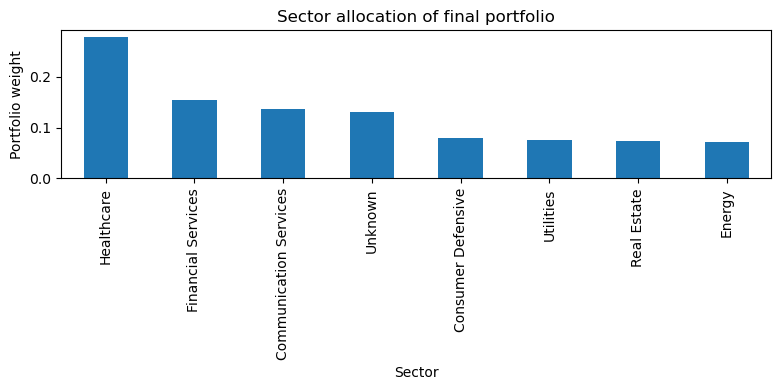

,Momentum_mean,Volatility_mean,AvgCorr_mean
Selected,0.150250,0.012419,0.083410
Universe,0.012488,0.017764,0.127745


In [37]:
# sector allocation bar chart
sector_weights = Portfolio_Final.groupby("Sector")["Weight"].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sector_weights.plot(kind="bar")
plt.ylabel("Portfolio weight")
plt.title("Sector allocation of final portfolio")
plt.tight_layout()
plt.show()

# factor comparison: selected vs full universe
selected_tickers = set(Portfolio_Final["Ticker"])
selected = meta_scored[meta_scored["Ticker"].isin(selected_tickers)]
universe = meta_scored

stats_table = pd.DataFrame({
    "Momentum_mean": [selected["Momentum"].mean(), universe["Momentum"].mean()],
    "Volatility_mean": [selected["Volatility"].mean(), universe["Volatility"].mean()],
    "AvgCorr_mean": [selected["AvgCorr"].mean(), universe["AvgCorr"].mean()],
    }, index=["Selected", "Universe"])

display(stats_table)


The above sector allocation chart shows our portfolio respects the assignment constraint of <= 40% in any single sector while still tilting toward sectors where our factors are most attractive.

The factor statistics table compares our selected stocks against the full universe. It is expected that:
- **Higher average Momentum:** For the selected set. Showing we tilt toward recent "winning" stocks
- **Lower average volatility:** Means our selected stocks have less fluctuation in returns, which supports our more stable and risk-efficient portfolio
- **Lower average correlation:** Strengthens diversification and reduces total portfolio risk and exposure to market-wide swings.

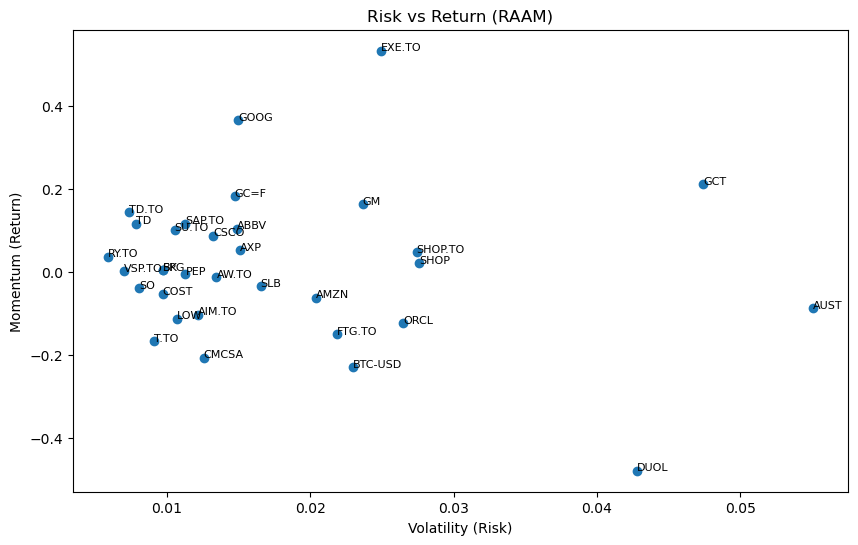

In [38]:
plt.figure(figsize=(10,6))
plt.scatter(meta_scored["Volatility"], meta_scored["Momentum"])

for i, txt in enumerate(meta_scored["Ticker"]):
    plt.text(meta_scored["Volatility"].iloc[i], meta_scored["Momentum"].iloc[i], txt, fontsize=8)

plt.xlabel("Volatility (Risk)")
plt.ylabel("Momentum (Return)")
plt.title("Risk vs Return (RAAM)")
plt.show()


The risk and return scatter plot compares each stocks risk against its return (volatility vs momentum). In the RAAM model we implemented, momentum was weighted heavily (40%) while volatility was rewarded when lower (30%). Thus, our goal was to identify stocks that offered strong return potential without extreme instability. On the graph, this ideal region lies in the upper-left to upper-middle area where momentum is high and volatility is moderate rather than excessive. Looking out our final portfolio, we create a diverse combination that achieves this goal. 

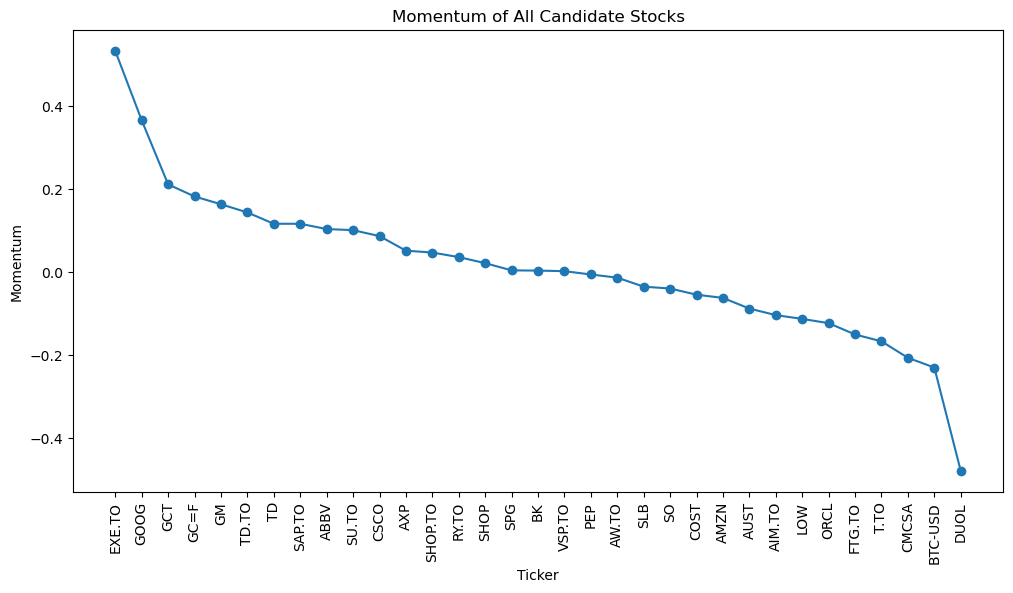

In [39]:
plt.figure(figsize=(12,6))
sorted_momentum = meta_scored.set_index("Ticker")["Momentum"].sort_values(ascending=False)
plt.plot(sorted_momentum.index, sorted_momentum.values, marker="o")
plt.title("Momentum of All Candidate Stocks")
plt.xlabel("Ticker")
plt.ylabel("Momentum")
plt.xticks(rotation=90)
plt.show()


The graph will visually confirm that the chosen stocks generally displayed stronger upward price movement compared to those that were excluded. By emphasizing positive momentum, the strategy aimed to capture stocks that were already demonstrating upward trends. Stocks with extremely low momentum such as BA and PYPL were discluded while stocks near the top of the line (CAT) were included. 

In [40]:
# export csv
Portfolio_Final[['Ticker', 'Shares']].to_csv('Stocks_Group_17.csv', index=False)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Nelson Kang, Mane Muradyan, Phelan Niu
